In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
from scipy import constants
from scipy.linalg import lstsq
from matplotlib.animation import FuncAnimation
from Simbo import generate_levels, getrand, setzero, exchange, recdist, accum, calc_Eav, calc_Bolt_ent, calc_av_ent, calc_prob_temp
plt.rcParams.update({'font.size': 6.5})

k_B = constants.value(u'Boltzmann constant')
h = constants.value(u'Planck constant')
c = constants.value(u'speed of light in vacuum')
nu = 500e2

42.0


<IPython.core.display.Javascript object>


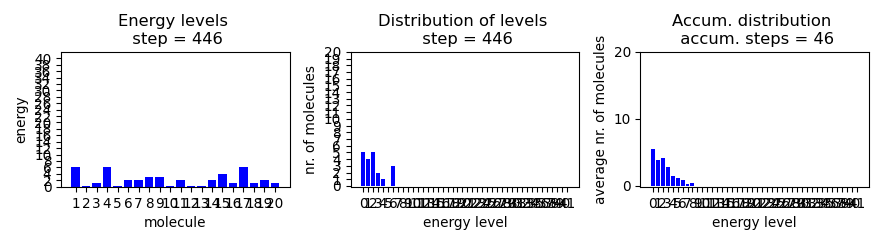

[[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05], [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.

In [13]:
#run short simulation
%matplotlib notebook

nop = 20 ##user input

#initialize
istep = 0
nstot = 40*nop
nseqv = 20*nop

if istep <= nseqv:
    
    #automatic generation of levels
    levels = generate_levels(2, nop)
    maxlev, idist, dist_sum, nstep = setzero(levels)
    
print(np.sum(levels))
      
#prepare graphs
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 2.5))
all_levels = []
all_distr = []
all_dist_sum = []

zero_array = []

for i in range(int(sum(levels))):
    zero_array.append(0.05)

#run
while istep < nstot:
    
    bef = istep
    
    #get random molecules
    ifrom, ito = getrand(nop)
    
    #exchange and update max levels
    levels, istep = exchange(ifrom, ito, nop, levels, istep, maxlev)
    
    if istep > bef: #exchange not possible sometimes (level[ifrom] = 0)
        
        #calculate distribution over energy levels
        distr, all_levels, all_distr = recdist(nop, levels, maxlev, all_levels, all_distr)
    
        #calculate accumulated distribution
        if istep > nseqv: #if equilibrated
            
            idist, dist_sum, all_dist_sum, nstep = accum(nop, maxlev, idist, distr, dist_sum, nstep, all_dist_sum) 
            nstep+=1
            
        else:
            
            all_dist_sum.append(zero_array)

print(all_dist_sum)
#animate plot data
def animation_frame(i):
    ax1.cla()

    labels1 = np.arange(1, nop+1, 1)
    trimmed_dist1 = all_levels[i]

    ax1.set_xticks(labels1)
    ax1.set_yticks(np.arange(0, maxlev, 2))
    ax1.set_xlabel('molecule')
    ax1.set_ylabel('energy')
    ax1.set_ylim(-0.2, maxlev)
    ax1.bar(x=labels1, height=trimmed_dist1, color='b')
    ax1.set_title(f'Energy levels \n step = {i}')

    ax2.cla()

    labels2 = np.arange(0, maxlev, 1)
    trimmed_dist2 = all_distr[i]
    ax2.set_xticks(labels2)
    ax2.set_yticks(np.arange(0, nop+1, 1))
    ax2.set_ylabel('nr. of molecules')
    ax2.set_xlabel('energy level')
    ax2.set_ylim(-0.2, nop)
    ax2.bar(x=labels2, height=trimmed_dist2, color='b')
    ax2.set_title(f'Distribution of levels \n step = {i}')

    ax3.cla()

    labels3 = np.arange(0, maxlev, 1)
    trimmed_dist3 = all_dist_sum[i]
    ax3.set_xticks(labels3)
    ax3.set_ylabel('average nr. of molecules')
    ax3.set_xlabel('energy level')
    ax3.set_ylim(-0.2, nop)
    ax3.bar(x=labels3, height=trimmed_dist3, color='b')
    if i > nseqv:
        ax3.set_title(f'Accum. distribution \n accum. steps = {i-nseqv}')
    else:
        ax3.set_title(f'Accum. distribution \n accum. steps = 0')

    plt.tight_layout()
    
frames_no = len(all_levels)
animation = FuncAnimation(fig, animation_frame, frames=frames_no, interval=50, repeat=False)

In [8]:
calc_Eav(maxlev, distr, nop)

Average energy: 24.8306e-21 J


3.4868 red.un. 2508.3681 K
Average energy: 29.9027e-21 J


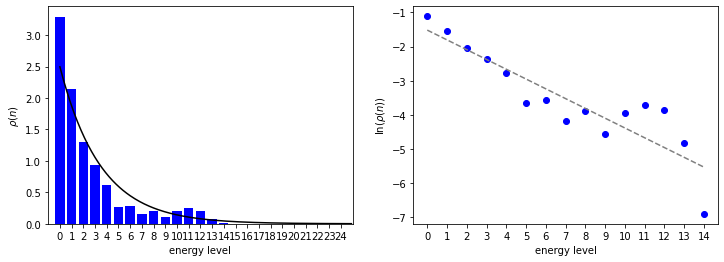

In [9]:
%matplotlib inline
calc_prob_temp(dist_sum, nop)

In [10]:
calc_Bolt_ent(nop, distr)

Statistical weight: 151200.0
Boltzmann entropy: 0.1647e-21 J/K


In [11]:
calc_av_ent(nop, dist_sum)

Statistical weight: 679431673.1
Average entropy: 0.2808e-21 J/K
